## DenseNet 稠密连接网络
DenseNet可以理解为ResNet的扩展

### 从ResNet到DenseNet
有泰勒展开式 Taylor expansion ,当x接近于0时\
![](img/2022-04-30-11-44-55.png)
同样ResNet将函数展开为\
$f(x) = x + g(x)$\
也就是说 ResNet将fx分解为两个部分 一个简单的线性项和一个复杂的非线性项.如果我们将f拓展成超过两部分的信息,这便是**DenseNet**
![](img/2022-04-30-12-36-35.png)


如图所示,两者关键区别在于右图使用连接  而非简单的相加
![](img/2022-04-30-12-38-04.png)
最后，将这些展开式结合到多层感知机中，再次减少特征的数量。 实现起来非常简单：我们不需要添加术语，而是将它们连接起来。 DenseNet这个名字由变量之间的“稠密连接”而得来，最后一层与之前的所有层紧密相连。
![](img/2022-04-30-12-38-40.png)


稠密网络主要有两部分构成:稠密块(Dense Block)和过渡层(transition layer) 前者定义如何连接输入和输出,而后者控制通道数量,使其不会过于复杂

### 稠密块

In [1]:
import torch
from torch import nn as nn
from torch.nn import functional as F
import sys 
import os
sys.path.append(os.path.abspath('../'))
import lmy
from icecream import ic

/home/anaconda3/envs/lmy/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


一个DenseBlock由多个卷积块组成,每个卷积块使用相同数量的输出通道.然而在前向传播的过程中,我们将每个卷积块的输入和输出在通道维连结

In [2]:
def conv_block(in_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(in_channels), nn.ReLU(),
        nn.Conv2d(in_channels, num_channels, kernel_size=3, padding=1)
    )


class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels*i+input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for block in self.net:
            Y = block(X)
            # ic(X.shape,Y.shape)
            X = torch.cat((X, Y), dim=1)  # 在通道维上进行连结
            # ic(X.shape)
        return X


下面例子中 (4,23,8,8) 23 = 3+10*2  卷积块的通道数控制了输出通道数相对于输入通道数的增长,因此也被称为
**增长率(growth rate)**

In [3]:
block = DenseBlock(num_convs=2, input_channels=3, num_channels=10)
X = torch.randn(4, 3, 8, 8)
Y = block(X)
Y.shape 

torch.Size([4, 23, 8, 8])

### 过渡层(transition layer)

由于每个稠密块都会带来通道数的增加,使用过多会使模型过于复杂,使用TL来控制模型的复杂度,原理就是1x1的卷积来减少通道数,并使用平均汇聚层减半高和宽 从而进一步降低模型复杂度.


In [4]:
def transition_block(input_channels,num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels),nn.ReLU(),
        nn.Conv2d(input_channels,num_channels,kernel_size=1),
        nn.AvgPool2d(kernel_size=2,stride=2)
    )

In [5]:
t_block = transition_block(23,10)
t_block(Y).shape

torch.Size([4, 10, 4, 4])

### DenseNet模型

In [6]:
b1 = nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
    nn.BatchNorm2d(64),nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
)

In [7]:
num_channels = 64
growth_rate = 32

# 在每个模块之间 ResNet通过残差块来减小高和宽,DenseNet使用过渡层
# 4个稠密块 每个稠密块四个卷积层 所以每个稠密块可以增加128个通道 共增加128*4=512通道
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(
        DenseBlock(num_convs, num_channels, growth_rate)
    )
    num_channels += growth_rate*num_convs
    
    if i == len(num_convs_in_dense_blocks)-1: 
        break
    blks.append(transition_block(num_channels,num_channels//2))
    num_channels //= 2


In [8]:
DenseNet = nn.Sequential(
    b1,
    *blks,
    nn.BatchNorm2d(num_channels),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10)
)


FashionMNIST数据集加载成功，训练集大小:60000,测试集大小:10000,数据集shape:torch.Size([1, 96, 96])
训练设备[device(type='cuda', index=0)]


100%|██████████| 10/10 [04:04<00:00, 24.41s/epoch]

loss:10.914%,train_acc:96.152%,test_acc:90.910%)


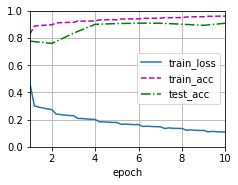

In [9]:
lmy.train_GPU_FASHION_MNIST(DenseNet,num_epochs=10,lr=.1,batch_size=256,resize=96,net_name='DenseNet')